In [1]:
import os
import shutil
from pathlib import Path
from subprocess import run

import matplotlib.pyplot as plt
import numpy as np
import ogstools as ot
import ogstools.variables as ov
import pyvista as pv

# Local
from meshing import create_fractured_cube_centered


## Path

In [2]:
OGS_PATH = None

if OGS_PATH is not None:
    os.environ["OGS_BIN_PATH"] = OGS_PATH
out_dir = Path(os.environ.get("OGS_TESTRUNNER_out_dir", "_out"))
out_dir.mkdir(parents=True, exist_ok=True)

fig_dir = out_dir / "figs"
fig_dir.mkdir(parents=True, exist_ok=True)

mesh_dir   = Path("_out/mesh")

![Schematic view of the model](schematic.png "Schematic view")

*Figure 1. Schematic view of the model.*


## Inputs

In [3]:
mesh_name  = "cube_frac_v"
lc         = 10 # m
lc_frac    = 2  # m
W, H, T    = 50.0, 50.0, 50.0 # m
theta_deg  = 0.0
b          = 4            # structured mesh: b = 2*lc_frac # m
center_z   = -100 # m

### Injection 

In [4]:
times = [0, 499.9, 500, 599.9, 600, 699.9, 700, 799.9, 800, 899.9, 900, 1000] # s
flow_vals = [0.0, 0.0, 4.167e-2, 4.167e-2, 8.334e-2, 8.334e-2, 1.2501e-1, 1.2501e-1, 1.6668e-1, 1.6668e-1, 2.0835e-1, 2.0835e-1] # m3/s
pressure_vals = [0.0, 0.0, 1e6, 1e6, 2e6, 2e6, 3e6, 3e6, 4e6, 4e6, 5e6, 5e6] # Pa

### Material propertieses

In [5]:
gneiss = {
    "young_sample": 83.9e9,
    "nu_sample": 0.21,
    "biot": 0.6,
    "porosity": 0.001,
    "permeability": 1e-19,
    "density_solid": 2750,
    "w_init": 1e-6,
}

fault = {
    "young_modulus": gneiss["young_sample"],
    "poisson_ratio": gneiss["nu_sample"],
    "biot": gneiss["biot"],
    "porosity": gneiss["porosity"],
    "density": gneiss["density_solid"],
    "permeability": (gneiss["w_init"] ** 2) / 12.0,
}


METHOD = "source"  # "source": injection source term; "pressure": Dirichlet pressure boundary condition.


## 3D mesh

### Gmsh

In [6]:
MSH_FILE = mesh_dir / f"{mesh_name}.msh"
MSH_FILE.parent.mkdir(parents=True, exist_ok=True)

create_fractured_cube_centered(
    MSH_FILE,
    lc=lc, lc_frac=lc_frac, W=W, T=T, H=H,
    theta_deg=theta_deg, b=b, center_z=center_z,
)

assert MSH_FILE.is_file(), f"Mesh not written: {MSH_FILE}"

### Generate the VTU meshes for OpenGeoSys (OGS)


In [7]:
def export_vtu_sets(msh_file: Path):
    out_dir = msh_file.parent
    if not msh_file.is_file():
        raise FileNotFoundError(f"Mesh not found: {msh_file}")

    meshes_dom = ot.meshes_from_gmsh(msh_file, dim=[3], log=False)
    for name, mesh in meshes_dom.items():
        pv.save_meshio(out_dir / f"{name}.vtu", mesh)


export_vtu_sets(MSH_FILE)

In [8]:
cwd = Path.cwd()
os.chdir(mesh_dir)

run(
    f"NodeReordering -o domain.vtu -i domain.vtu",
    shell=True,
    check=True,
)

run(
    "identifySubdomains -f -m domain.vtu -s 1e-8 -- "
    "physical_group_F_*.vtu  physical_group_L_*.vtu physical_group_CENTER.vtu",
    shell=True,
    check=True,
)

os.chdir(cwd)

[2025-10-14 12:57:21.821] [ogs] [info] Reordering nodes... 
[2025-10-14 12:57:21.829] [ogs] [info] Corrected 0 elements.
[2025-10-14 12:57:21.848] [ogs] [info] VTU file written.
[2025-10-14 12:57:21.917] [ogs] [info] Mesh reading time: 0.0262344 s
[2025-10-14 12:57:21.918] [ogs] [info] MeshNodeSearcher construction time: 0.000572534 s
[2025-10-14 12:57:21.918] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 1.2666e-05 s
[2025-10-14 12:57:21.918] [ogs] [warning] There is already a 'bulk_node_ids' property present in the subdomain mesh 'physical_group_F_BACK' and it is not equal to the newly computed values.
[2025-10-14 12:57:21.918] [ogs] [info] Overwriting 'bulk_node_ids' property.
[2025-10-14 12:57:21.922] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshElements took 0.00364691 s
[2025-10-14 12:57:21.922] [ogs] [info] identifySubdomainMesh(): identifySubdomainMeshNodes took 5.2079e-05 s
[2025-10-14 12:57:21.922] [ogs] [warning] There is already a 'bulk

## Run OGS

### prj file

In [9]:
PROJECT_BASENAME = "HM_init_3D" if METHOD == "pressure" else "HM_init_3D_source"
prj_in  = Path(f"{PROJECT_BASENAME}.prj")
prj_out = out_dir / f"{PROJECT_BASENAME}_updated.prj"

param_name = "injectionFlowRate_Inlet"


def build_step_expr(ts, vs, var="t"):
    """
    Build a right-open step function using ternary operators:
      (t < t1 ? v0 :
       t < t2 ? v1 :
       ...
       vN)
    If vs has len(ts)-1, it is extended with the last value.
    """
    if len(vs) == len(ts) - 1:
        vs = vs + [vs[-1]]
    parts = [f"{var} < {ts[i]:g} ? {vs[i-1]:.6g} :" for i in range(1, len(ts))]
    return "(" + "\n           ".join(parts) + f"\n           {vs[-1]:.6g})"

selected_vals = flow_vals if METHOD == "source" else pressure_vals
expr = build_step_expr(times, selected_vals, var="t")

prj = ot.Project(input_file=prj_in, output_file=prj_out)

try:
    prj.replace_parameter_value(name="E1",  value=gneiss["young_sample"])
    prj.replace_parameter_value(name="nu1", value=gneiss["nu_sample"])

    def set_medium_props(mid, biot, k_perm, poro, rho_solid):
        prj.replace_medium_property_value(mediumid=mid, name="biot_coefficient", value=biot)
        prj.replace_medium_property_value(mediumid=mid, name="permeability",    value=k_perm)
        prj.replace_medium_property_value(mediumid=mid, name="porosity",        value=poro)
        prj.replace_phase_property_value(mediumid=mid, phase="Solid", name="density", value=rho_solid)

    for mid in (0, 1):
        set_medium_props(mid, gneiss["biot"], gneiss["permeability"], gneiss["porosity"], gneiss["density_solid"])
    for mid in (2,):
        set_medium_props(mid, fault["biot"], fault["permeability"], fault["porosity"], fault["density"])
except NameError:
    pass

n_type = prj.replace_text(
    "Function",
    xpath=f".//parameters/parameter[name='{param_name}']/type"
)
n_expr = prj.replace_text(
    expr,
    xpath=f".//parameters/parameter[name='{param_name}']/expression"
)

if n_type == 0 or n_expr == 0:
    raise ValueError(
        f"Parameter '{param_name}' not found or missing <type>/<expression> in {prj_in}.\n"
        f"XPath used: .//parameters/parameter[name='{param_name}']/*"
    )

prj.replace_text("genesis_HM_init", xpath=".//time_loop/output/prefix")
prj.write_input()

print("METHOD:", METHOD)
print("Updated parameter:", param_name)
print("Expression:\n", expr)
print("Written to:", prj_out)


METHOD: source
Updated parameter: injectionFlowRate_Inlet
Expression:
 (t < 499.9 ? 0 :
           t < 500 ? 0 :
           t < 599.9 ? 0.04167 :
           t < 600 ? 0.04167 :
           t < 699.9 ? 0.08334 :
           t < 700 ? 0.08334 :
           t < 799.9 ? 0.12501 :
           t < 800 ? 0.12501 :
           t < 899.9 ? 0.16668 :
           t < 900 ? 0.16668 :
           t < 1000 ? 0.20835 :
           0.20835)
Written to: _out/HM_init_3D_source_updated.prj


### Plot the input injection profile (flow rate or pressure) for double-checking

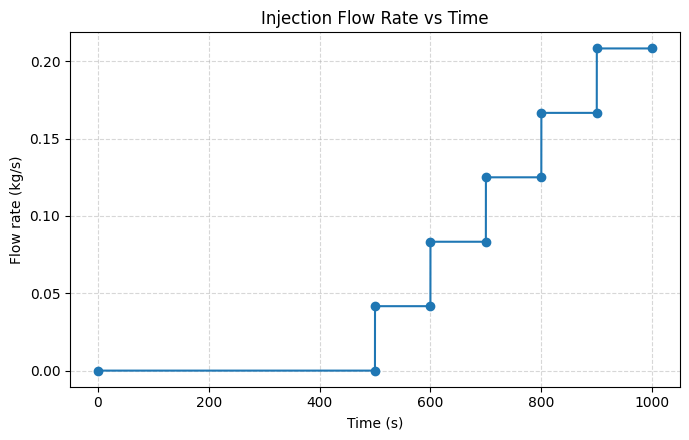

In [22]:
def maybe(a): 
    try: 
        return eval(a)
    except NameError:
        return None

ts_curve = maybe("coords_str")
vs_curve = maybe("vals")
pmax_here = maybe("pmax")

if ts_curve is not None and vs_curve is not None and pmax_here is not None:
    times_curve = [float(t) for t in ts_curve.split()]
    p_curve_MPa = [v * (pmax_here / 1e6) for v in vs_curve]
else:
    times_curve, p_curve_MPa = None, None

pressure_times = maybe("times") if maybe("pressure_vals") is not None else None
pressure_vals_MPa = [v/1e6 for v in pressure_vals] if maybe("pressure_vals") is not None else None

flow_times = maybe("times") if maybe("flow_vals") is not None else None
flow_vals_here = flow_vals if maybe("flow_vals") is not None else None

if METHOD == "pressure" and pressure_times is not None and pressure_vals_MPa is not None:
    plt.figure(figsize=(7, 4.5))
    plt.plot(pressure_times, pressure_vals_MPa, marker="o")
    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (MPa)")
    plt.title("Injection Pressure vs Time")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.show()

if METHOD == "source" and flow_times is not None and flow_vals_here is not None:
    plt.figure(figsize=(7, 4.5))
    plt.plot(flow_times, flow_vals_here, marker="o")
    plt.xlabel("Time (s)")
    plt.ylabel("Flow rate (kg/s)")
    plt.title("Injection Flow Rate vs Time")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("injection_rate.png", dpi=480)
    plt.show()

if times_curve is not None and p_curve_MPa is not None:
    plt.figure(figsize=(7, 4.5))
    plt.plot(times_curve, p_curve_MPa, marker="o")
    plt.xlabel("Time (s)")
    plt.ylabel("Pressure (MPa)")
    plt.title("Equivalent Pressure vs Time (from curve)")
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.tight_layout()
    plt.savefig("pressure_bc_center.png", dpi=480)
    plt.show()


In [11]:
prj.run_model(logfile=out_dir / "ogs_run.txt",
              #path="~/Code/ogs6/build/release-lis/bin",
              #path="~/Code/ogs6/build/release-petsc/bin",
              args=f"-o {out_dir} -m {mesh_dir}")

Project file written to output.
Simulation: _out/HM_init_3D_source_updated.prj
Status: finished successfully.
Execution took 177.78029561042786 s


## Post-processing

In [12]:
pv.set_jupyter_backend("static")
pvd_path = out_dir / "genesis_HM_init.pvd"


PRESSURE_NAME = "pressure"
SIGMA_TENSOR = "sigma"
DISP_NAME = "displacement"
CLIP_SIDE = "positive"

ms = ot.MeshSeries(pvd_path)
idx_first = 1 if len(ms) > 1 else 0
mesh_first = ms[idx_first]
mesh_last = ms[-1]

def promote_to_point(ds, name):
    if name in ds.point_data: return ds.point_data[name]
    if name in ds.cell_data:  return ds.cell_data_to_point_data(copy=True).point_data[name]
    raise KeyError(name)

def u_mag(ds):
    u = promote_to_point(ds, DISP_NAME)
    return np.linalg.norm(np.asarray(u), axis=1)

def ensure_pressure(ds):
    if PRESSURE_NAME not in ds.point_data:
        try: ds.point_data[PRESSURE_NAME] = promote_to_point(ds, PRESSURE_NAME)
        except KeyError: pass

def ensure_sigma_vm(ds):
    if "sigma_vm" in ds.point_data: return
    base = None
    for nm in (SIGMA_TENSOR, "Sigma", "stress", "Stress"):
        if nm in ds.point_data or nm in ds.cell_data:
            base = nm; break
    if base is None: return
    A = np.asarray(promote_to_point(ds, base))
    if A.ndim != 2 or A.shape[0] != ds.n_points: return
    if A.shape[1] == 6:
        sxx, syy, szz, sxy, syz, szx = [A[:, i] for i in range(6)]
    elif A.shape[1] == 9:
        sxx, syy, szz = A[:, 0], A[:, 4], A[:, 8]
        sxy = 0.5*(A[:,1]+A[:,3]); syz = 0.5*(A[:,5]+A[:,7]); szx = 0.5*(A[:,2]+A[:,6])
    else:
        return
    vm = np.sqrt(0.5*((sxx-syy)**2 + (syy-szz)**2 + (szz-sxx)**2 + 6.0*(sxy**2 + syz**2 + szx**2)))
    ds.point_data["sigma_vm"] = vm

def find_velocity_array_name(ds):
    names = list(ds.point_data.keys()) + list(ds.cell_data.keys())
    cand = []
    for nm in names:
        arr = ds.point_data.get(nm, None)
        if arr is None: arr = ds.cell_data.get(nm, None)
        if arr is None: continue
        a = np.asarray(arr)
        if a.ndim == 2 and a.shape[1] >= 3:
            if ("darcy" in nm.lower()) or ("veloc" in nm.lower()):
                cand.append(nm)
    if cand:
        cand.sort(key=lambda s: (("darcy" not in s.lower()), ("veloc" not in s.lower()), s.lower()))
        return cand[0]
    for nm in names:
        arr = ds.point_data.get(nm, None)
        if arr is None: arr = ds.cell_data.get(nm, None)
        if arr is None: continue
        a = np.asarray(arr)
        if a.ndim == 2 and a.shape[1] >= 3:
            return nm
    return None

def ensure_velocity_auto(ds):
    nm = find_velocity_array_name(ds)
    if nm is None: return None
    V = np.asarray(promote_to_point(ds, nm))
    mag = np.linalg.norm(V, axis=1)
    mag = np.clip(mag, 1e-20, None)
    ds.point_data["darcy_velocity"] = V
    ds.point_data["darcy_velocity_magnitude"] = mag
    ds.point_data["log_darcy_velocity_magnitude"] = np.log10(mag)
    ds.set_active_vectors("darcy_velocity")
    return "darcy_velocity"

def clipped(mesh):
    b = mesh.bounds
    o = ((b[0]+b[1])/2, (b[2]+b[3])/2, (b[4]+b[5])/2)
    invert = (CLIP_SIDE == "negative")
    h = mesh.clip(normal=(0,1,0), origin=o, invert=invert).copy()
    h.point_data["|u|"] = u_mag(h)
    ensure_pressure(h)
    ensure_sigma_vm(h)
    ensure_velocity_auto(h)
    return h, b

def add_z0_plane(pl, bounds):
    xmin, xmax, ymin, ymax, zmin, zmax = bounds
    cx, cy = 0.5*(xmin+xmax), 0.5*(ymin+ymax)
    plane = pv.Plane(center=(cx, cy, 0.0), direction=(0,0,1),
                     i_size=(xmax-xmin), j_size=(ymax-ymin),
                     i_resolution=1, j_resolution=1)
    pl.add_mesh(plane, color="black", opacity=0.08, show_edges=False)
    pl.add_mesh(pv.Line((cx, cy, 0.0), (cx, cy, zmax)), color="black", line_width=2)

def show_clip_3d(dataset, bounds, scalars, title, png_path,
                 cmap, symmetric=False, unit=None,
                 azim_deg=25, elev_deg=15, dist_factor=3.0):
    bar_title = f"{scalars}" + (f" ({unit})" if unit else "")
    sbar = dict(title=bar_title, title_font_size=20, label_font_size=16,
                fmt="%.2e" if unit in ("Pa","m") else None,
                position_x=0.25, position_y=0.12, width=0.5, height=0.05, vertical=False)
    pl = pv.Plotter(off_screen=False)
    pl.set_background("white")
    pl.add_title(title, font_size=18)
    pl.add_axes()
    pl.show_bounds(grid="front", location="outer", all_edges=True, xtitle="X", ytitle="Y", ztitle="Z")
    add_z0_plane(pl, bounds)
    if scalars in dataset.point_data:
        clim = None
        if symmetric:
            arr = np.asarray(dataset.point_data[scalars])
            vmax = np.nanpercentile(np.abs(arr), 99.5)
            if np.isfinite(vmax) and vmax > 0:
                clim = (-vmax, vmax)
        pl.add_mesh(dataset, scalars=scalars, cmap=cmap, clim=clim,
                    show_edges=True, smooth_shading=True, opacity=1.0,
                    scalar_bar_args=sbar, backface_params={"color":"lightgray"})
    pl.disable_parallel_projection()
    c = np.array(dataset.center)
    diag = float(np.linalg.norm(np.array(bounds[1::2]) - np.array(bounds[::2])))
    base = np.array([0.0, -1.0, 0.0]) * (dist_factor * diag)
    az = np.radians(azim_deg); el = np.radians(elev_deg)
    Rz = np.array([[ np.cos(az), -np.sin(az), 0],
                   [ np.sin(az),  np.cos(az), 0],
                   [          0,           0, 1]])
    Rx = np.array([[1,          0,           0],
                   [0,  np.cos(el), -np.sin(el)],
                   [0,  np.sin(el),  np.cos(el)]])
    offset = Rx @ (Rz @ base)
    cam_pos = c + offset
    pl.camera.position = tuple(cam_pos)
    pl.camera.focal_point = tuple(c)
    pl.camera.up = (0, 0, 1)
    pl.show(screenshot=str(png_path))


WINDOW_SIZE = (1600, 1200)

def scene_length(bounds):
    xmin, xmax, ymin, ymax, zmin, zmax = bounds
    dx, dy, dz = (xmax - xmin), (ymax - ymin), (zmax - zmin)
    return float(np.sqrt(dx*dx + dy*dy + dz*dz))

def compute_arrow_factor(ds, bounds, target_frac=0.08, use_magnitude=True):
    L = scene_length(bounds)
    if L <= 0:
        return 1.0, use_magnitude

    mags = np.asarray(ds.point_data.get("darcy_velocity_magnitude", None))
    if mags is None or not np.isfinite(mags).any():
        # fall back to constant-length arrows
        return target_frac * L, False

    vmax = float(np.nanpercentile(mags, 99.0))  
    if not np.isfinite(vmax) or vmax <= 0:
        return target_frac * L, False

    if use_magnitude:
        return (target_frac * L) / vmax, True
    else:
        return target_frac * L, False

    

def render_velocity(ds, bounds, title, outpng, az=35, el=25, dist_factor=3.0,
                    target_frac=0.08, scale_by_magnitude=True, stride=None):
    vname = ensure_velocity_auto(ds)
    if vname is None:
        return

    factor, do_scale_by_mag = compute_arrow_factor(ds, bounds, target_frac, use_magnitude=scale_by_magnitude)

    glyph_kwargs = dict(orient="darcy_velocity", factor=factor)
    if do_scale_by_mag:
        glyph_kwargs["scale"] = "darcy_velocity_magnitude"  # length ∝ |v|
    else:
        glyph_kwargs["scale"] = False                       # constant length arrows

    src = ds if stride is None else ds.extract_points(np.arange(0, ds.n_points, max(int(stride), 1)))
    arrows = src.glyph(**glyph_kwargs)

    sbar = dict(title="log₁₀(|Darcy velocity|) [m/s]", title_font_size=20, label_font_size=16,
                position_x=0.25, position_y=0.12, width=0.5, height=0.05, vertical=False)

    pl = pv.Plotter(off_screen=True, window_size=WINDOW_SIZE)
    pl.set_background("white")
    pl.add_title(title, font_size=18)
    pl.add_axes()
    pl.show_bounds(grid="front", location="outer", all_edges=True, xtitle="X", ytitle="Y", ztitle="Z")
    add_z0_plane(pl, bounds)

    pl.add_mesh(ds, scalars="log_darcy_velocity_magnitude", cmap="viridis",
                show_edges=False, smooth_shading=True, opacity=1.0,
                scalar_bar_args=sbar, backface_params={"color":"lightgray"})

    pl.add_mesh(arrows, color="black", lighting=False)  
    pl.add_mesh(ds.outline(), color="black", line_width=2)

    c = np.array(ds.center)
    diag = scene_length(bounds)
    base = np.array([0.0, -1.0, 0.0]) * (dist_factor * diag)
    azr, elr = np.radians(az), np.radians(el)
    Rz = np.array([[ np.cos(azr), -np.sin(azr), 0],
                   [ np.sin(azr),  np.cos(azr), 0],
                   [          0,           0, 1]])
    Rx = np.array([[1,          0,           0],
                   [0,  np.cos(elr), -np.sin(elr)],
                   [0,  np.sin(elr),  np.cos(elr)]])
    cam_pos = c + (Rx @ (Rz @ base))
    pl.camera.position = tuple(cam_pos)
    pl.camera.focal_point = tuple(c)
    pl.camera.up = (0, 0, 1)

    pl.screenshot(filename=str(outpng))
    pl.show()
    pl.close()

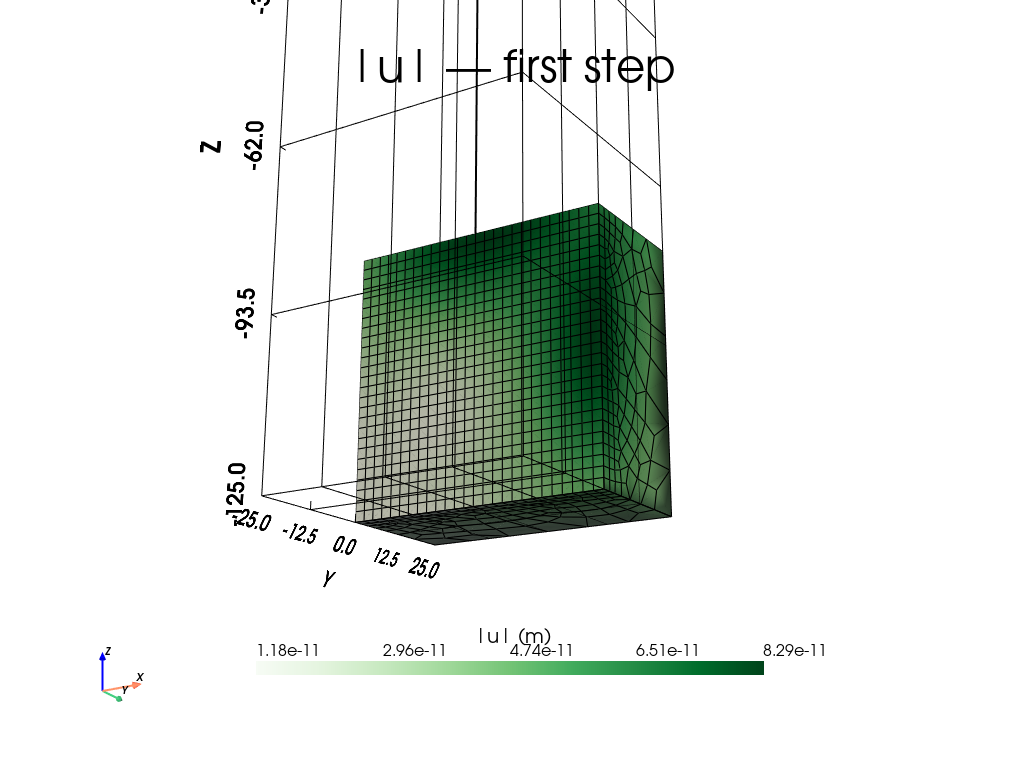

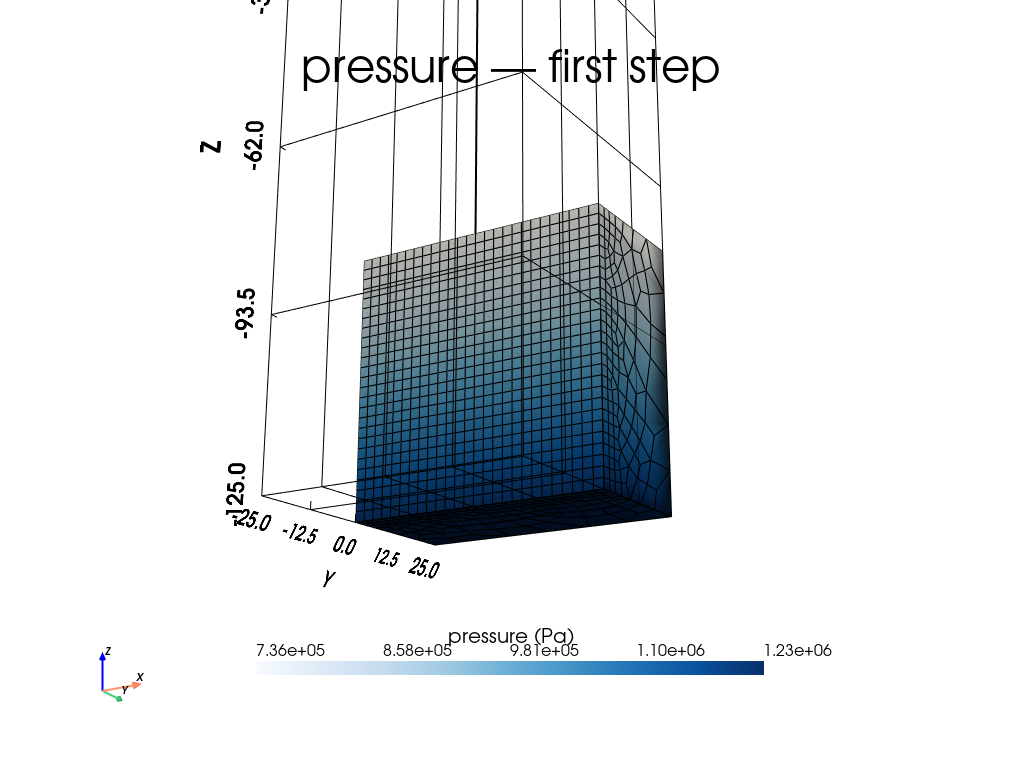

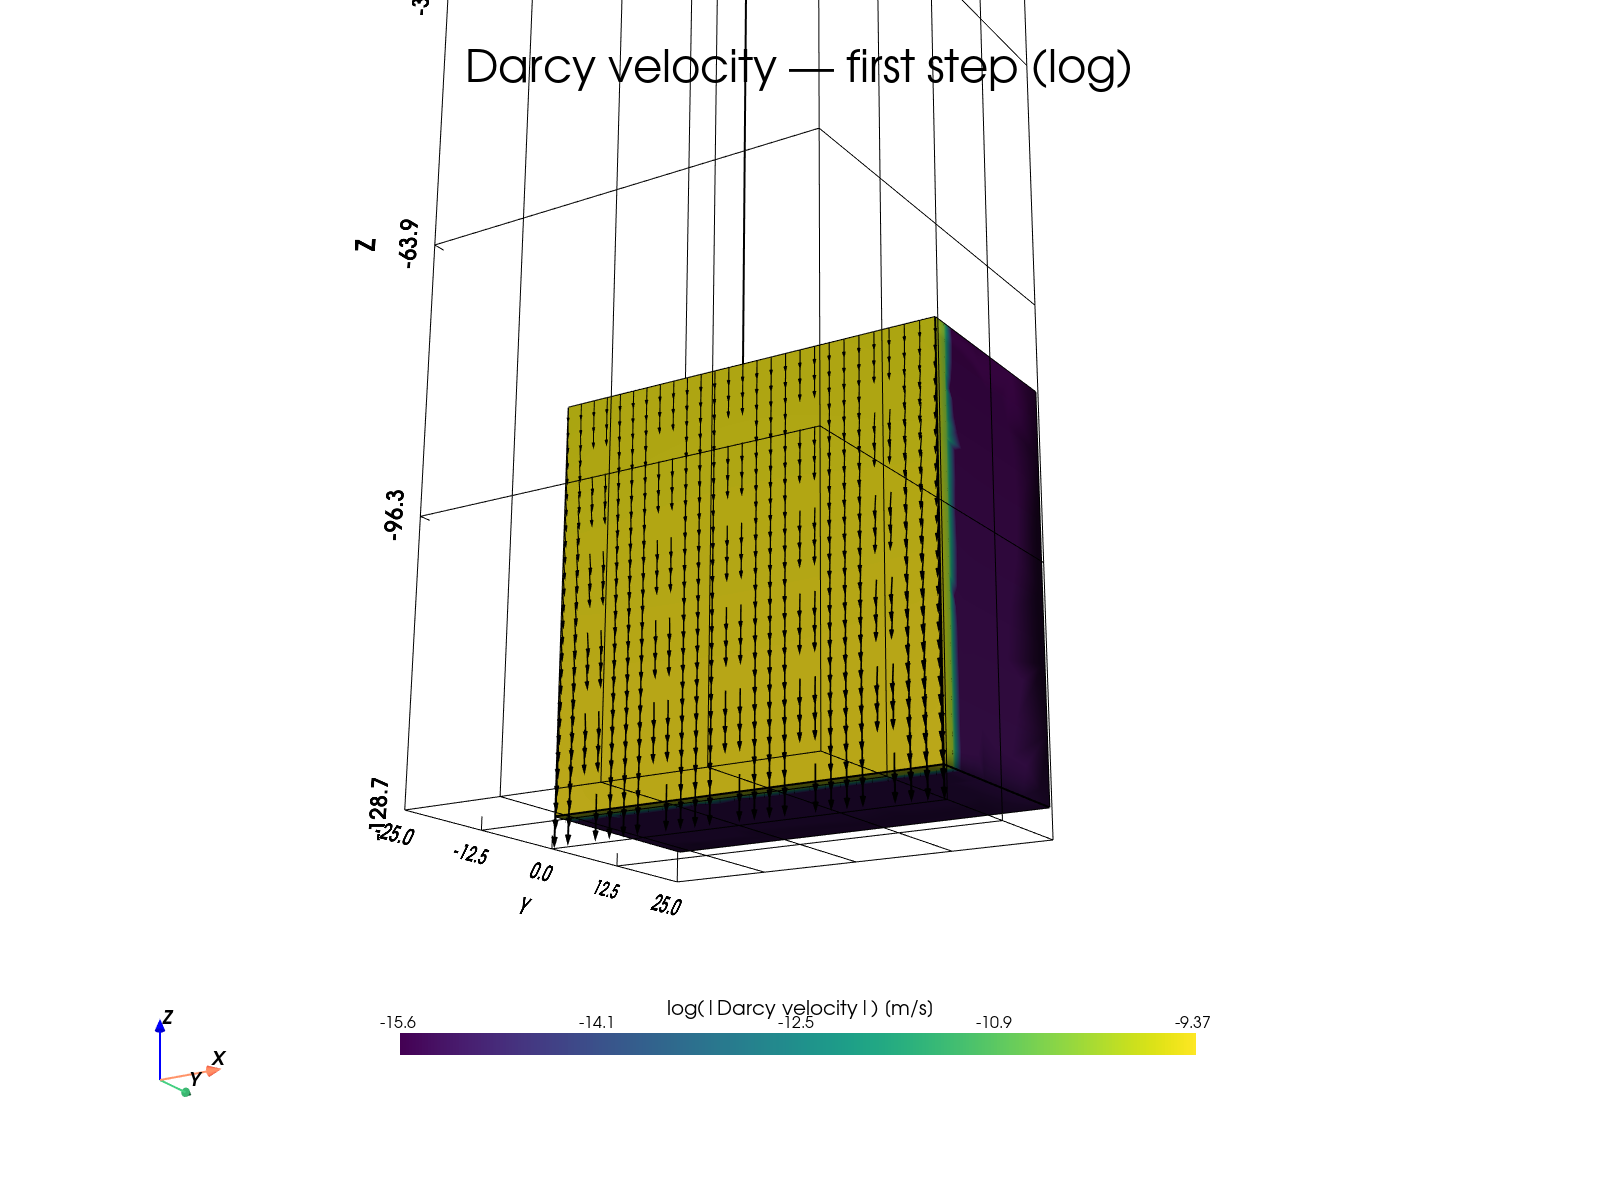

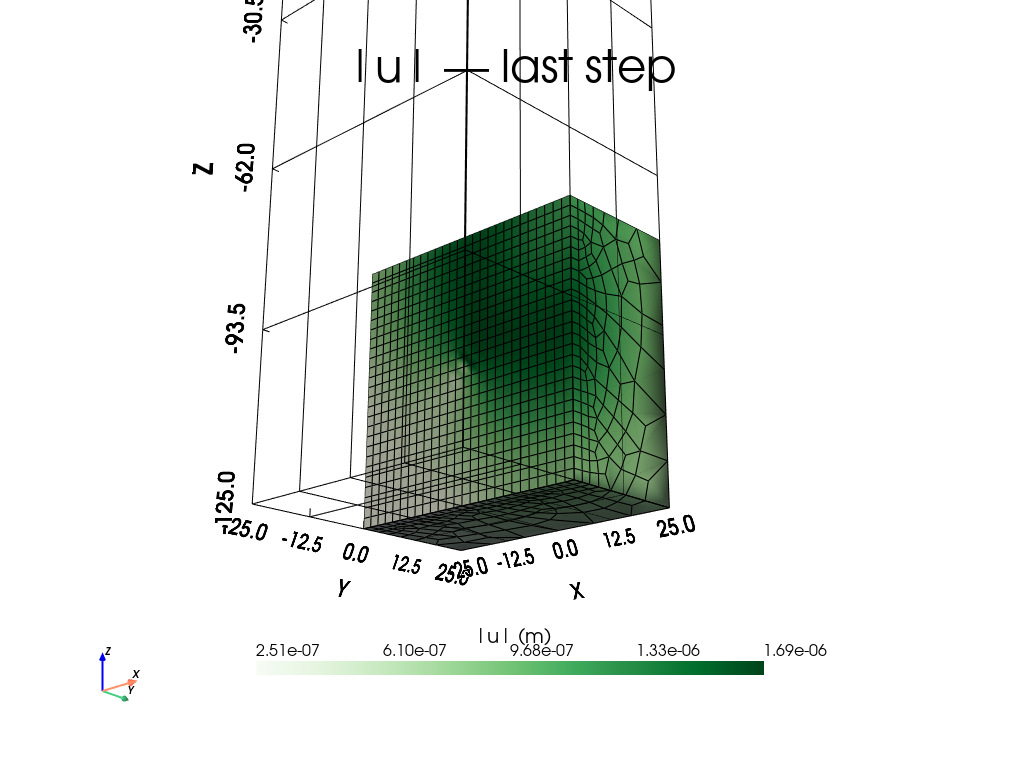

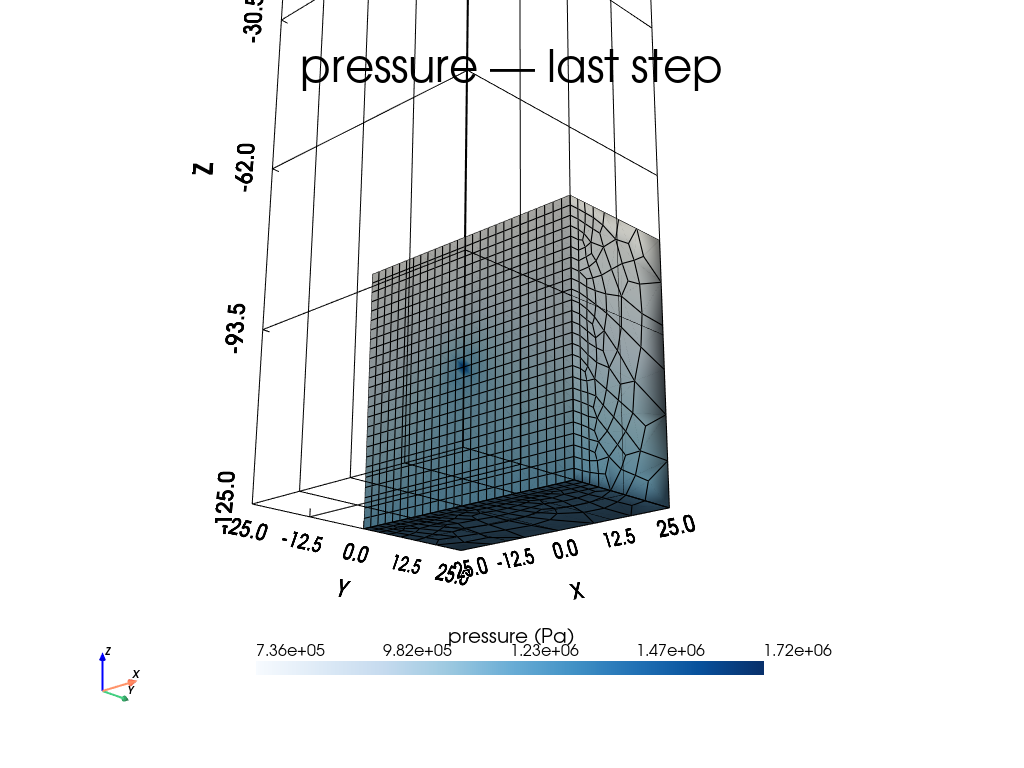

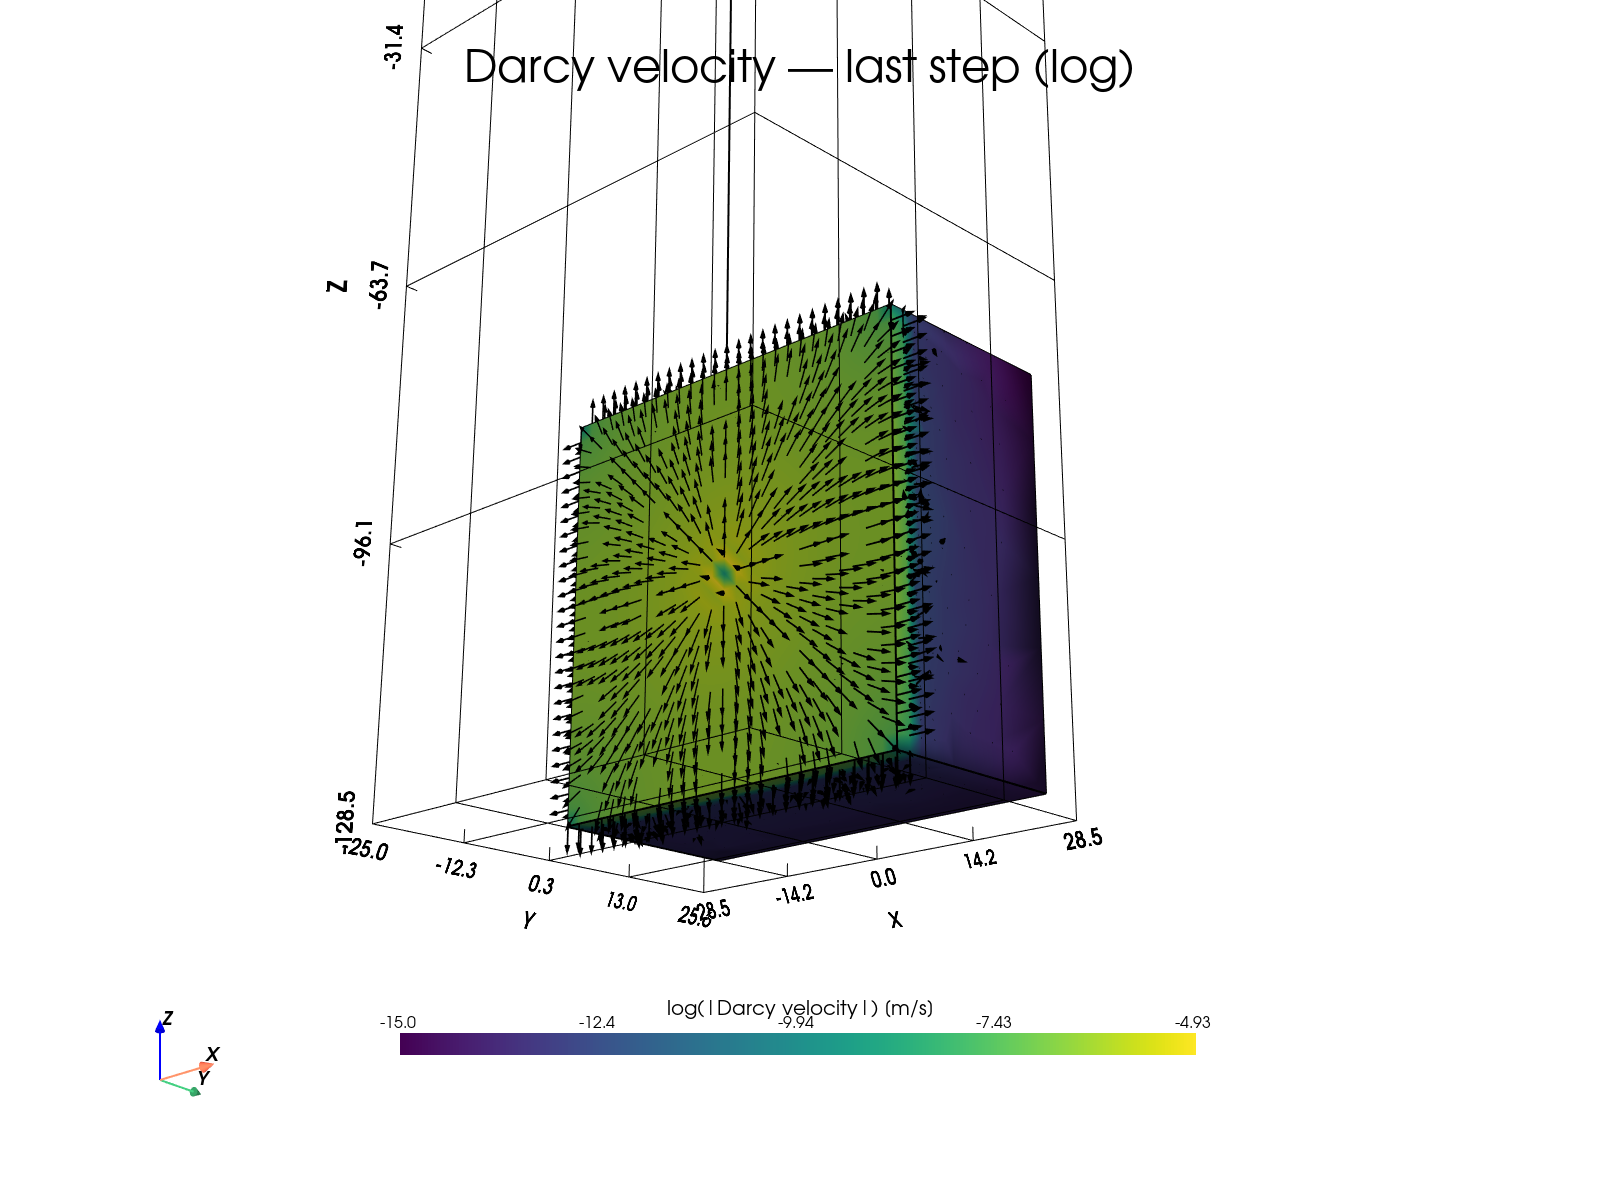

Saved to: /home/wenqing/Projects/Fault/_out/figs


In [13]:
half_first, b_first = clipped(mesh_first)
half_last,  b_last  = clipped(mesh_last)

AZIM_FIRST, ELEV_FIRST = 30, 20
AZIM_LAST,  ELEV_LAST  = 40, 25
#--------------------------------------------------------------------------------------------------------
show_clip_3d(half_first, b_first, "|u|", "|u| — first step",
             fig_dir / "first_clip3D_u.png", cmap="Greens", unit="m",
             azim_deg=AZIM_FIRST, elev_deg=ELEV_FIRST)

if PRESSURE_NAME in half_first.point_data:
    show_clip_3d(half_first, b_first, PRESSURE_NAME, "pressure — first step",
                 fig_dir / "first_clip3D_pressure.png", cmap="Blues", unit="Pa",
                 azim_deg=AZIM_FIRST, elev_deg=ELEV_FIRST)

render_velocity(half_first, b_first,
                "Darcy velocity — first step (log)",
                fig_dir / "first_clip3D_velocity_log_arrows.png",
                az=AZIM_FIRST, el=ELEV_FIRST,
                target_frac=0.04,  
                scale_by_magnitude=True,
                stride=5)         
#--------------------------------------------------------------------------------------------------------

show_clip_3d(half_last, b_last, "|u|", "|u| — last step",
             fig_dir / "last_clip3D_u.png", cmap="Greens", unit="m",
             azim_deg=AZIM_LAST, elev_deg=ELEV_LAST)

if PRESSURE_NAME in half_last.point_data:
    show_clip_3d(half_last, b_last, PRESSURE_NAME, "pressure — last step",
                 fig_dir / "last_clip3D_pressure.png", cmap="Blues", unit="Pa",
                 azim_deg=AZIM_LAST, elev_deg=ELEV_LAST)

render_velocity(half_last, b_last,
                "Darcy velocity — last step (log)",
                fig_dir / "last_clip3D_velocity_const_arrows.png",
                az=AZIM_LAST, el=ELEV_LAST,
                target_frac=0.04,
                scale_by_magnitude=False,
                stride=5)
#--------------------------------------------------------------------------------------------------------
print("Saved to:", fig_dir.resolve())

### Plot pressure profile at Injection point (output)

100%|████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:00<00:00, 36.19it/s]


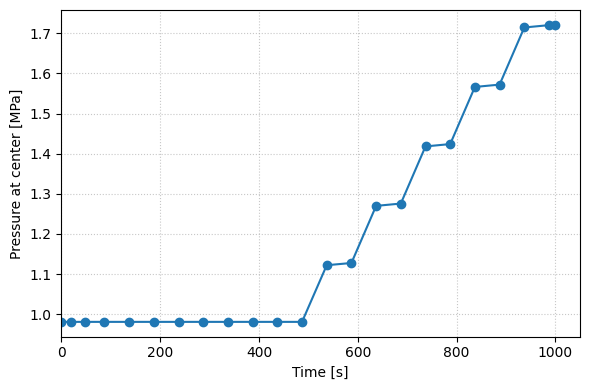

In [15]:
pvd_path = Path("_out/genesis_HM_init.pvd")
center = (0.0, 0.0, center_z)

ms = ot.MeshSeries(pvd_path).scale(time=("s", "s"))
probe = ot.MeshSeries.extract_probe(ms, [center])

t = probe.timevalues
p_pa = probe.point_data["pressure"][:, 0]
p_mpa = p_pa/1e6 

tmin, tmax = 0.0, 1050.0
mask = (t >= tmin) & (t <= tmax)

plt.figure(figsize=(6, 4))
plt.plot(t[mask], p_mpa[mask], marker="o")
plt.xlabel("Time [s]")
plt.ylabel("Pressure at center [MPa]")
plt.grid(True, linestyle=":", alpha=0.7)
plt.xlim(tmin, tmax)
plt.tight_layout()
plt.savefig("pressure_at_center.png", dpi=480)
plt.show()

